In [1]:
import pandas as pd
import numpy as np
from datetime import datetime

from sklearn.metrics import classification_report
from sklearn.metrics import balanced_accuracy_score as bmac

from sklearn.metrics import confusion_matrix 
from sklearn.model_selection import train_test_split 

In [21]:
def prepare_submission(y_graded, comment = ""):
    y_out_template = np.genfromtxt ('sample.csv', delimiter=",")[1:]
    filename = datetime.now().strftime("%m.%d.%H.%M")+"_"+comment+".csv"
    print(filename)
    y_out=y_out_template
    y_out[:,1] = y_graded
    np.savetxt(filename, y_out, delimiter=",",header="id,y",  comments='')

In [3]:
X_train_file = 'X_train.csv'
y_train_file = 'y_train.csv'
X_test_file  = 'X_test.csv'

labels_df = pd.read_csv(y_train_file)
bare_df   = pd.read_csv(X_train_file)
test_df   = pd.read_csv(X_test_file)

bare_df.insert(0,'y',labels_df['y'])

labels_df = labels_df.set_index('id')
bare_df   = bare_df  .set_index('id')
test_df   = test_df  .set_index('id')

print('bare_df.shape =', bare_df.shape)
print('test_df.shape  =', test_df.shape)
print('y distribution: ')
print(bare_df['y'].value_counts())
print('We are told that \"Test set has the same class imbalance as the training set.\"')

bare_df.shape = (4800, 1001)
test_df.shape  = (4100, 1000)
y distribution: 
1    3600
2     600
0     600
Name: y, dtype: int64
We are told that "Test set has the same class imbalance as the training set."


In [4]:
def mean_std_normalise(df):
    return (df-df.mean())/df.std()

def min_max_normalise(df):
    return (2*df-df.min()-df.max())/(df.max()-df.min())

# I have this in a function bacause it makes it easy to 
# make a new train/test split and normalise etc
def preprocess(split):
    
    #Normalizing and preparing feature and label matrices
    
    nrm_df = mean_std_normalise(bare_df.drop(columns='y'))
    nrm_df['y'] = bare_df['y']
    # dividing X, y into train and test data 
    df_train, df_test = train_test_split(nrm_df, test_size = split)

    X_train = df_train.drop(columns='y').values
    y_train = df_train['y'].values
    X_AML   = mean_std_normalise(test_df).values
    n_AML, _ = np.shape(n_AML)
    weights={0:1/.125, 1:1/.75, 2:1/.125}

    n_train = len(y_train)

    X_test = df_test.drop(columns='y').values
    y_test = df_test['y'].values
    n_test = len(y_test)
    print("train shape = ", np.shape(X_train))
    print("test shape  = ", np.shape(X_test))
    print()
    print('n0test = %.1f%%'%(100/n_test*np.sum((y_test == 0))))
    print('n1test = %.1f%%'%(100/n_test*np.sum((y_test == 1))))
    print('n2test = %.1f%%'%(100/n_test*np.sum((y_test == 2))))
    print()
    print('n0train = %.1f%%'%(100/n_train*np.sum((y_train == 0))))
    print('n1train = %.1f%%'%(100/n_train*np.sum((y_train == 1))))
    print('n2train = %.1f%%'%(100/n_train*np.sum((y_train == 2))))
    print()
    return X_train, y_train, n_train, weights, X_test, y_test, n_test, X_AML, n_AML

In [11]:
X_train, y_train, n_train, weights, X_test, y_test, n_test, X_AML = preprocess(0.01)
samwe = [weights[int(yi)] for yi in y_test] 

train shape =  (4752, 1000)
test shape  =  (48, 1000)

n0test = 14.6%
n1test = 70.8%
n2test = 14.6%

n0train = 12.5%
n1train = 75.0%
n2train = 12.5%



In [12]:
from sklearn.svm import SVC
svc = SVC(kernel='rbf', 
          class_weight=weights, 
          gamma=0.8e-4, C=1, # result of cross validation
          probability=True)

svc.fit(X_train, y_train)
svc_pred  = svc.predict(X_test)
svc_train = svc.predict(X_train)
print('Plain predictions')
print('train BMAC =', bmac(y_train, svc_train))
print('test  BMAC =', bmac(y_test, svc_pred))
print(classification_report(y_test, svc_pred, sample_weight = samwe))
print()

Plain predictions
train BMAC = 0.7857623858078782
test  BMAC = 0.7787114845938375
              precision    recall  f1-score   support

           0       0.71      0.71      0.71      56.0
           1       0.81      0.76      0.79 45.33333333333334
           2       0.82      0.86      0.84      56.0

    accuracy                           0.78 157.33333333333334
   macro avg       0.78      0.78      0.78 157.33333333333334
weighted avg       0.78      0.78      0.78 157.33333333333334




In [13]:
AML_y  = svc.predict(X_AML)

In [16]:
svc_pr_conf = svc.predict_proba(X_test)
pr_confidence = [svc_pr_conf[i,y_test[i]] for i in range(n_test)]
svc_tr_conf = svc.predict_proba(X_train)
tr_confidence = [svc_tr_conf[i,y_train[i]] for i in range(n_train)]
AML_conf  = svc.predict_proba(X_AML)
AML_confidence = [AML_conf[i,AML_y[i]] for i in range(4100)]

<IPython.core.display.Javascript object>


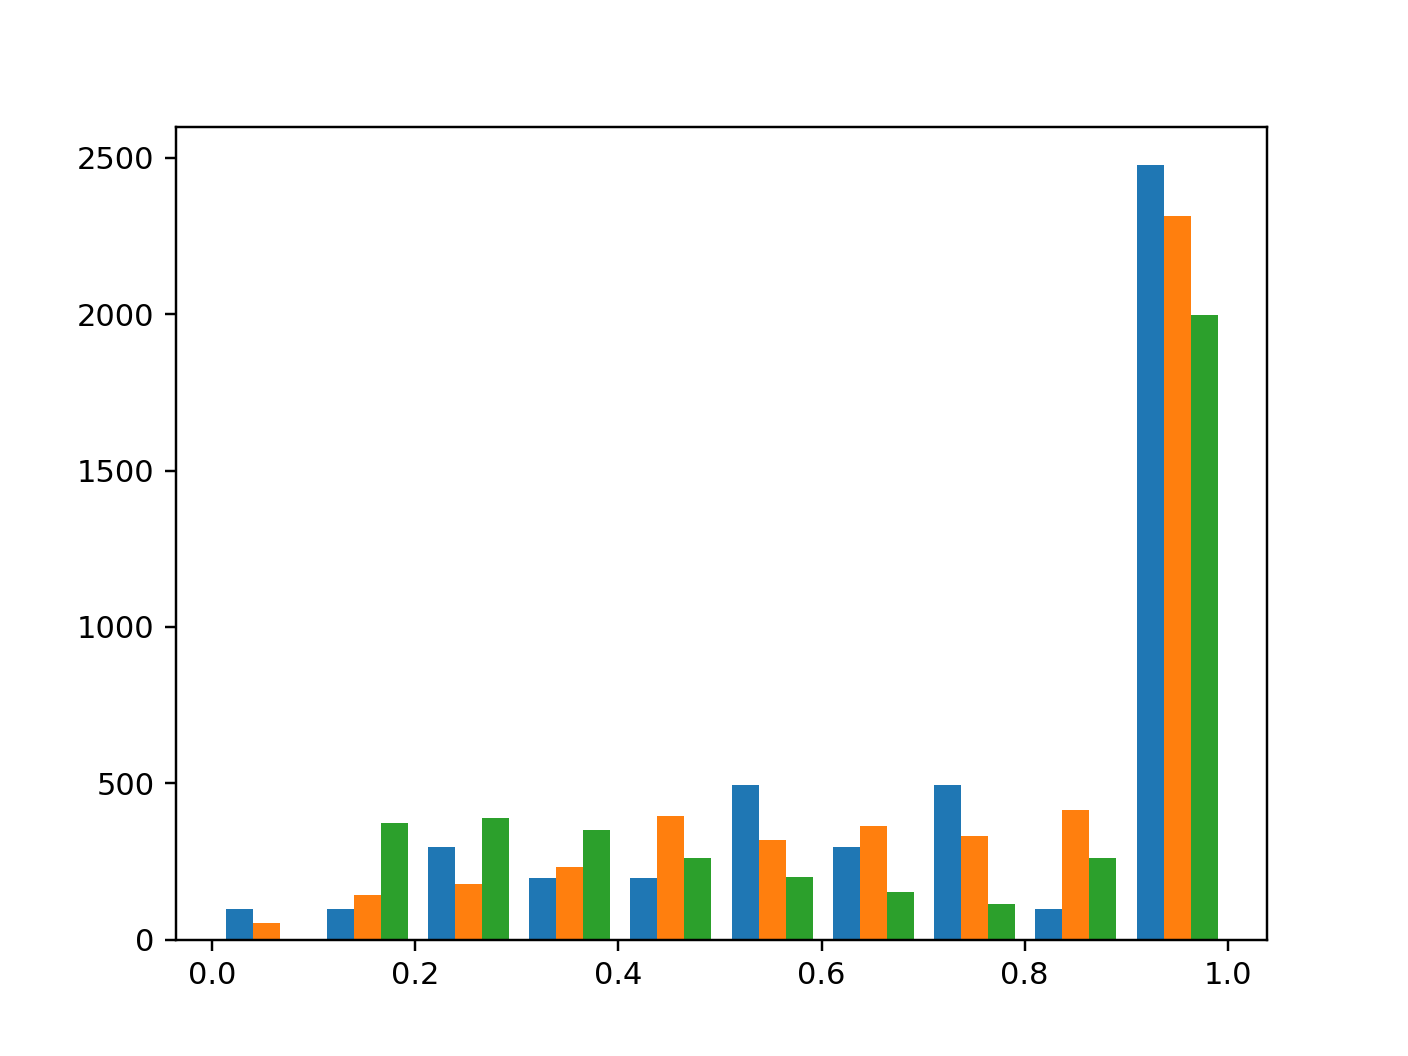

In [19]:
%matplotlib notebook
from matplotlib import pyplot as plt
plt.hist((pr_confidence*99, tr_confidence, AML_confidence))
pass

In [22]:
prepare_submission(AML_y, "seb")

11.15.22.32_seb.csv
